In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import CondensedNearestNeighbour

In [2]:
def make_data(sep):
    """
    `make_data` creates artificial data using sklearn `make_classification` function.
    It returns a pandas DataFrame that consists of 2 features and the a 2-class target 
    column.

    sep [float]: The factor multiplying the hypercube size. Larger values spread out the 
    clusters/classes and make the classification task easier.
    """
    X, y = make_classification(
        n_samples=1000,
        n_features=2,
        n_redundant=0,
        n_clusters_per_class=1,
        weights=[0.99],
        class_sep=sep,
        random_state=42
    )

    X = pd.DataFrame(X, columns=["varA", "varB"])
    y = pd.Series(y)
    return X, y


 0    985
1     15
dtype: int64


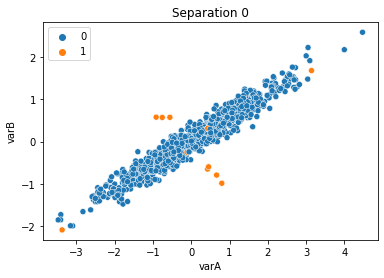


 0    985
1     15
dtype: int64


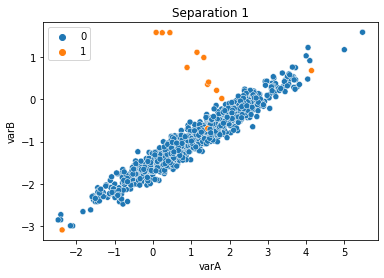


 0    985
1     15
dtype: int64


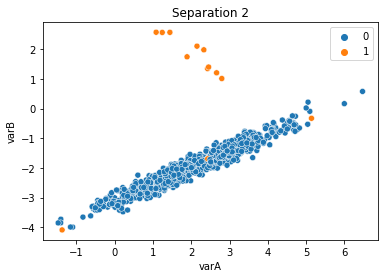

In [3]:
# Visualization of data used in this notebook
for sep in np.arange(0, 3):
    X, y = make_data(sep)
    print(f"\n {y.value_counts()}")
    sns.scatterplot(data=X, x="varA", y="varB", hue=y)
    plt.title(f"Separation {sep}")
    plt.show()

## Undersampling with condensed nearest neighbours

### Well-separated classes

In [4]:
X, y = make_data(sep=2)

# As the choice of the first point to add to the set is random, each run of the algorithm
# will yield different condensed dataset
cnn = CondensedNearestNeighbour(sampling_strategy="auto", n_neighbors=1, random_state=42)
X_resampled, y_resampled = cnn.fit_resample(X, y)

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
y.value_counts()

0    985
1     15
dtype: int64

In [7]:
X_resampled.shape, y_resampled.shape

((43, 2), (43,))

In [8]:
y_resampled.value_counts()

0    28
1    15
dtype: int64

Text(0.5, 1.0, 'Undersampled dataset')

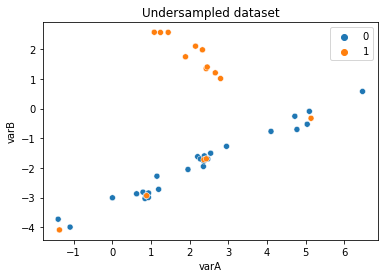

In [9]:
# The resampled dataset contains points from the majority class
# that are close to the minority class
sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)
plt.title("Undersampled dataset")

### Less separable dataset

In [10]:
# If one makes the classes less separable, intuitively, the condensed dataset should have more points
X, y = make_data(sep=0.5)

cnn = CondensedNearestNeighbour(sampling_strategy="auto", n_neighbors=1, random_state=42)
X_resampled, y_resampled = cnn.fit_resample(X, y)

In [11]:
print(f"Original shape: {X.shape, y.shape}\n")
print(f"Undersampled dataset shape: {X_resampled.shape, y_resampled.shape}")

Original shape: ((1000, 2), (1000,))

Undersampled dataset shape: ((55, 2), (55,))


Text(0.5, 1.0, 'Original dataset')

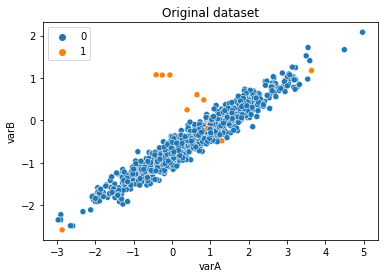

In [12]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)
plt.title("Original dataset")

Text(0.5, 1.0, 'Undersampled dataset')

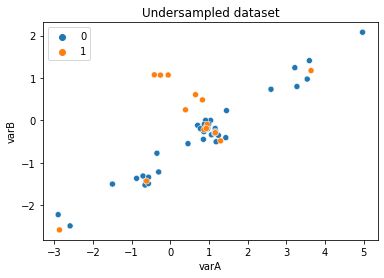

In [13]:
sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)
plt.title("Undersampled dataset")

# KDD 2004

## Condensed dataset

In [14]:
# Dataset path
dataset_folder = pathlib.Path("../../../Datasets")
dataset_file = "kdd2004.csv"
dataset_path = dataset_folder/dataset_file

if not dataset_path.exists():
    raise FileExistsError(f"This path doesn't correspond to any file: {dataset_path.resolve()}")

In [15]:
# As condensed nearest neighbour is iterative when constructing
# the set S, it is a bit slow. We only take a chunk of the original
# dataset to speed up computations as this is just an example
df = pd.read_csv(dataset_path).sample(10000)

df["target"] = df["target"].map({-1:0, 1:1})

print(f"The shape of the dataset: {df.shape}\n")
print(f"The distribution of the target column:\n {df.target.value_counts(normalize=True)}")

The shape of the dataset: (10000, 75)

The distribution of the target column:
 0    0.9918
1    0.0082
Name: target, dtype: float64


In [16]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(labels=["target"], axis=1), 
                                                    df["target"],
                                                    train_size=0.7)
X_train.shape, X_test.shape

((7000, 74), (3000, 74))

In [17]:
cnn = CondensedNearestNeighbour(sampling_strategy="auto", n_neighbors=1, random_state=42)
X_resampled, y_resampled = cnn.fit_resample(X_train, y_train)

In [18]:
print(f"Original train dataset shape: {X_train.shape, y_train.shape}\n")
print(f"Orignal train dataset target distribution:\n {y_train.value_counts()}\n")
print(30 * "-")
print(f"\nResampled train dataset shape: {X_resampled.shape, y_resampled.shape}\n")
print(f"Resampled train dataset target distribution:\n {y_resampled.value_counts()}")

Original train dataset shape: ((7000, 74), (7000,))

Orignal train dataset target distribution:
 0    6943
1      57
Name: target, dtype: int64

------------------------------

Resampled train dataset shape: ((345, 74), (345,))

Resampled train dataset target distribution:
 0    288
1     57
Name: target, dtype: int64


Text(0.5, 1.0, 'Original dataset')

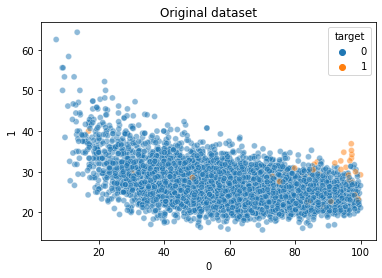

In [19]:
sns.scatterplot(data=X_train, x="0", y="1", hue=y_train, alpha=0.5)
plt.title("Original dataset")

Text(0.5, 1.0, 'Condensed dataset')

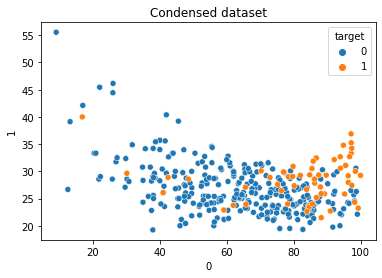

In [20]:
sns.scatterplot(data=X_resampled, x="0", y="1", hue=y_resampled)
plt.title("Condensed dataset")

## Models performance comparison
This is a not a real comparison, just want to know if we can see a big difference in performance

In [21]:
def build_run_rf(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=4)
    rf.fit(X_train, y_train)

    print("Train set\n")
    train_pred = rf.predict_proba(X_train)
    print(f"Random forest ROC-AUC: {roc_auc_score(y_train, train_pred[:, 1])}\n")

    print("Test set\n")
    test_pred = rf.predict_proba(X_test)
    print(f"Random forest ROC-AUC: {roc_auc_score(y_test, test_pred[:, 1])}")

In [22]:
# Original dataset
build_run_rf(X_train, X_test, y_train, y_test)

Train set

Random forest ROC-AUC: 0.9987113109000356

Test set

Random forest ROC-AUC: 0.9528067226890756


In [23]:
# Resampled dataset
build_run_rf(X_resampled, X_test, y_resampled, y_test)

Train set

Random forest ROC-AUC: 0.9989035087719298

Test set

Random forest ROC-AUC: 0.9512201680672269
